In [1]:
import torch
import torch.nn as nn
from torch import Tensor
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader,SubsetRandomSampler,ConcatDataset
import torch.nn.functional as F

In [2]:
import sys
sys.path.insert(0, "/home1/smaruj/AkitaMini-pytorch")  # Add the directory where "ledidi" is located
from model import SeqNN
from helper import plot_map, from_upper_triu, upper_triangular_to_vector_skip_diagonals

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [4]:
model = SeqNN()

# Load the saved model weights
model.load_state_dict(torch.load('/home1/smaruj/AkitaMini-pytorch/best_model.pth'))

/tmp/SLURM_241185/ipykernel_1638771/2425661507.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/home1/smaruj/AkitaMini-pytorch/best_mod

<All keys matched successfully>

In [5]:
model = model.to(device)

In [6]:
# Set the model to evaluation mode (important for inference)
model.eval()

SeqNN(
  (stochastic_reverse_complement): StochasticReverseComplement()
  (stochastic_shift): StochasticShift()
  (conv_block_1): ConvBlock(
    (conv): Conv1d(4, 96, kernel_size=(11,), stride=(1,), padding=(5,), bias=False)
    (batch_norm): BatchNorm1d(96, eps=0.001, momentum=0.0735, affine=True, track_running_stats=True)
    (pool): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_tower): ConvTower(
    (conv_tower): Sequential(
      (0): ReLU()
      (1): Conv1d(96, 96, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (2): BatchNorm1d(96, eps=0.001, momentum=0.0735, affine=True, track_running_stats=True)
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): ReLU()
      (5): Conv1d(96, 96, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (6): BatchNorm1d(96, eps=0.001, momentum=0.0735, affine=True, track_running_stats=True)
      (7): MaxPool1d(kernel_size=2, stride=2, padd

In [7]:
from torchinfo import summary

summary(model, input_size=(2, 4, 32768), col_names=["output_size", "num_params"])

Layer (type:depth-idx)                   Output Shape              Param #
SeqNN                                    [2, 1, 1953]              --
├─StochasticReverseComplement: 1-1       [2, 4, 32768]             --
├─StochasticShift: 1-2                   [2, 4, 32768]             --
├─ConvBlock: 1-3                         [2, 96, 4096]             --
│    └─Conv1d: 2-1                       [2, 96, 32768]            4,224
│    └─BatchNorm1d: 2-2                  [2, 96, 32768]            192
│    └─MaxPool1d: 2-3                    [2, 96, 4096]             --
├─ConvTower: 1-4                         [2, 96, 64]               --
│    └─Sequential: 2-4                   [2, 96, 64]               --
│    │    └─ReLU: 3-1                    [2, 96, 4096]             --
│    │    └─Conv1d: 3-2                  [2, 96, 4096]             46,080
│    │    └─BatchNorm1d: 3-3             [2, 96, 4096]             192
│    │    └─MaxPool1d: 3-4               [2, 96, 2048]             --
│    │

In [8]:
X = torch.load("/scratch1/smaruj/ledidi_targets/X.pt", weights_only=True)

In [9]:
modified_vector_tensor = torch.load("/scratch1/smaruj/ledidi_targets/modified_vector.pt", weights_only=True)

In [ ]:
    # def get_affected_bins(self, changed_indices):
    #     """
    #     Determine which bins contain changed indices.
    #     Also include ±1 bin for safety.
    #     """
    #     slice_start, slice_end = changed_indices
    
    #     # Compute correct bin indices
    #     start_bin = slice_start // self.bin_size
    #     end_bin = slice_end // self.bin_size  # Ensure proper bin inclusion
        
    #     affected_bins = set(range(start_bin, end_bin + 1))  # Directly affected bins

    #     # Include ±1 neighboring bins
    #     if start_bin > 0:
    #         affected_bins.add(start_bin - 1)
    #     if end_bin < self.num_bins - 1:
    #         affected_bins.add(end_bin + 1)

    #     return sorted(affected_bins)  # Ensure ordered output

In [10]:
# to ensure the local, forked ledidi is used
# not the one installed using pip

import sys
sys.path.insert(0, "/home1/smaruj/ledidi")  # Add the directory where "ledidi" is located
from ledidi import Ledidi

In [ ]:
X.shape, modified_vector_tensor.shape

In [ ]:
X.dtype, modified_vector_tensor.dtype

In [ ]:
# wrapper = Ledidi(model, (1, 32768, 4), verbose=True, batch_size=1,
#                  input_loss=torch.nn.L1Loss(reduction='sum'), 
#                  output_loss=torch.nn.MSELoss(), # default losses
#                  max_iter=20000,
#                  early_stopping_iter=20000
#                  ).cuda()

In [11]:
start_index = 10752
end_index = 11264

In [12]:
seq_length = end_index - start_index

In [13]:
wrapper = Ledidi(model, verbose=True, batch_size=10,
                 input_loss=torch.nn.L1Loss(reduction='sum'), 
                 output_loss=torch.nn.L1Loss(reduction='sum'),
                 max_iter=20000,
                 early_stopping_iter=2000,
                 slice_length=seq_length, 
                 slice_index=21,
                 use_semifreddo=False,
                #  lr=5.0,
                 return_history=True
                 ).cuda()

Gradients enabled for weights: True
Model in train mode: False
Weights shape torch.Size([1, 4, 512])


In [14]:
slice_torch = X[:,:,start_index : end_index]

In [15]:
X_l_flank = X[:,:,start_index - 512*2 : start_index]
X_r_flank = X[:,:,end_index : end_index + 512*2]

In [ ]:
# x_bar, history = wrapper.fit_transform(X, modified_vector_tensor)
# if use_semifreddo=True
# x_bar = wrapper.fit_transform(slice_torch, modified_vector_tensor, X_l_flank=X_l_flank, X_r_flank=X_r_flank)
x_bar, history = wrapper.fit_transform(slice_torch, modified_vector_tensor, X_l_flank=X_l_flank, X_r_flank=X_r_flank)

In [ ]:
x_bar.shape

In [16]:
# if use_semifreddo=False
# x_bar = wrapper.fit_transform(X, modified_vector_tensor, X_l_flank=X_l_flank, X_r_flank=X_r_flank)
x_bar, history = wrapper.fit_transform(X, modified_vector_tensor, X_l_flank=X_l_flank, X_r_flank=X_r_flank)

iter=I	input_loss=0.0	output_loss=79.79	total_loss=79.79	time=0.0
iter=100	input_loss=31.2	output_loss=73.08	total_loss=76.2	time=0.8285
iter=200	input_loss=20.4	output_loss=73.09	total_loss=75.13	time=0.7142
iter=300	input_loss=15.8	output_loss=73.02	total_loss=74.6	time=0.7121
iter=400	input_loss=13.6	output_loss=73.0	total_loss=74.36	time=0.713
iter=500	input_loss=14.0	output_loss=72.95	total_loss=74.35	time=0.714
iter=600	input_loss=14.1	output_loss=72.9	total_loss=74.31	time=0.7129
iter=700	input_loss=14.2	output_loss=72.92	total_loss=74.34	time=0.7134
iter=800	input_loss=12.5	output_loss=72.93	total_loss=74.18	time=0.7144
iter=900	input_loss=14.4	output_loss=72.85	total_loss=74.29	time=0.7132
iter=1000	input_loss=13.0	output_loss=72.96	total_loss=74.26	time=0.7145
iter=1100	input_loss=14.6	output_loss=72.85	total_loss=74.31	time=0.7144
iter=1200	input_loss=14.9	output_loss=72.84	total_loss=74.33	time=0.7151
iter=1300	input_loss=15.3	output_loss=72.84	total_loss=74.37	time=0.7171


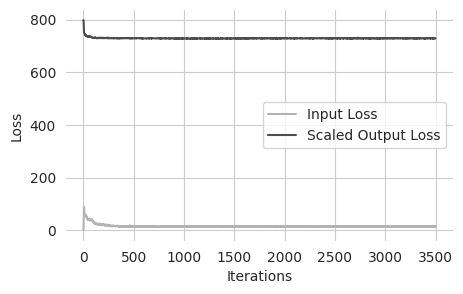

In [17]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

scaled_output_loss = numpy.array(history['output_loss']) * 10

plt.figure(figsize=(5, 3))
plt.plot(history['input_loss'], c='0.7', label="Input Loss")
plt.plot(scaled_output_loss, c='0.3', label="Scaled Output Loss")
plt.legend(fontsize=10)
plt.xlabel("Iterations")
plt.ylabel("Loss")

seaborn.despine(left=True, bottom=True)
plt.show()

In [ ]:
X_new = X.clone()
X_new = X_new.repeat(10, 1, 1)

In [ ]:
X_new[:,:,start_index:end_index] = x_bar

In [ ]:
(X_new[0,:,:] != X_new[1,:,:]).sum()

In [ ]:
for i in range(10):
    print("sequence", i)
    print("edits =", (X[0,:,:] != X_new[i,:,:]).sum() // 2)

In [ ]:
x_bar.shape

In [18]:
for i in range(10):
    print("sequence", i)
    print("edits =", (x_bar[i,:,:] != X).sum() // 2)

sequence 0
edits = tensor(12, device='cuda:0')
sequence 1
edits = tensor(13, device='cuda:0')
sequence 2
edits = tensor(12, device='cuda:0')
sequence 3
edits = tensor(11, device='cuda:0')
sequence 4
edits = tensor(13, device='cuda:0')
sequence 5
edits = tensor(12, device='cuda:0')
sequence 6
edits = tensor(11, device='cuda:0')
sequence 7
edits = tensor(13, device='cuda:0')
sequence 8
edits = tensor(11, device='cuda:0')
sequence 9
edits = tensor(11, device='cuda:0')


In [ ]:
# Get predictions
with torch.no_grad():
    # q_prediction = model(x_bar)
    q_prediction = model(X_new)

In [ ]:
q_prediction.shape

In [ ]:
plot_map(from_upper_triu(q_prediction[0], matrix_len=64, num_diags=2), vmin=-0.6, vmax=0.6, palette="RdBu_r", width=5, height=5)

In [ ]:
for i in range(5):
    print(i)
    plot_map(from_upper_triu(q_prediction[i], matrix_len=64, num_diags=2), vmin=-0.6, vmax=0.6, palette="RdBu_r", width=5, height=5)